<a href="https://colab.research.google.com/github/2129535/AAPL-Stock-Prediction-via-News-Sentiment-Machine-Learning/blob/main/Modelli_ML_finanza_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data preprocessing & cleaning

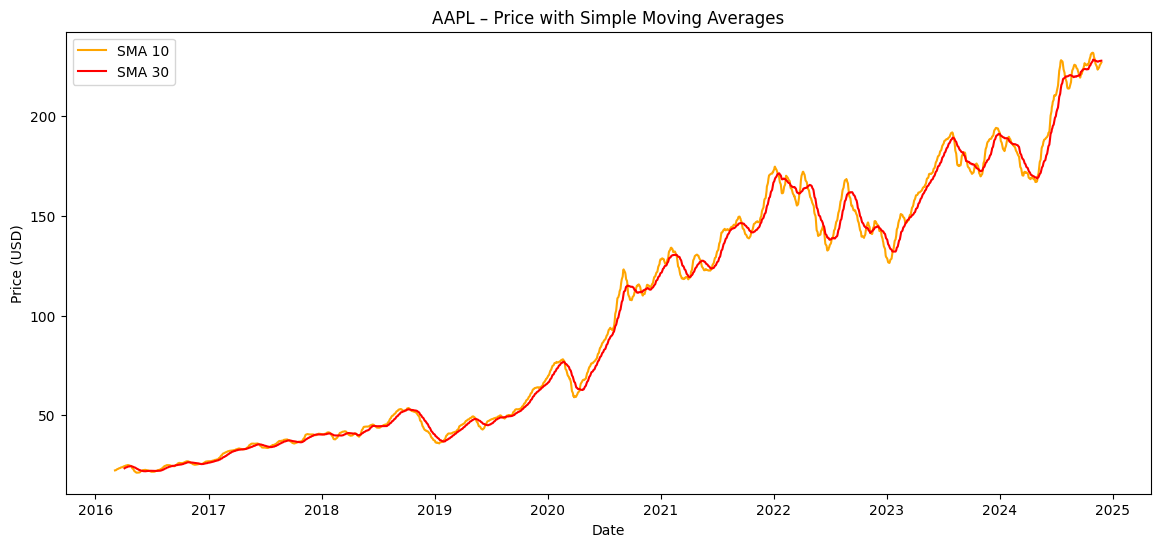

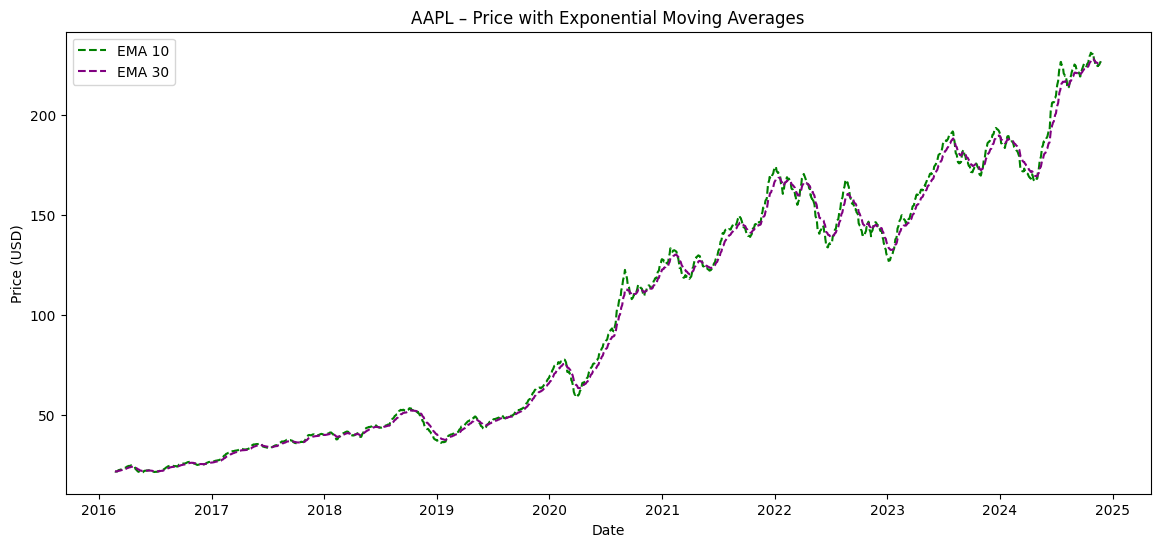

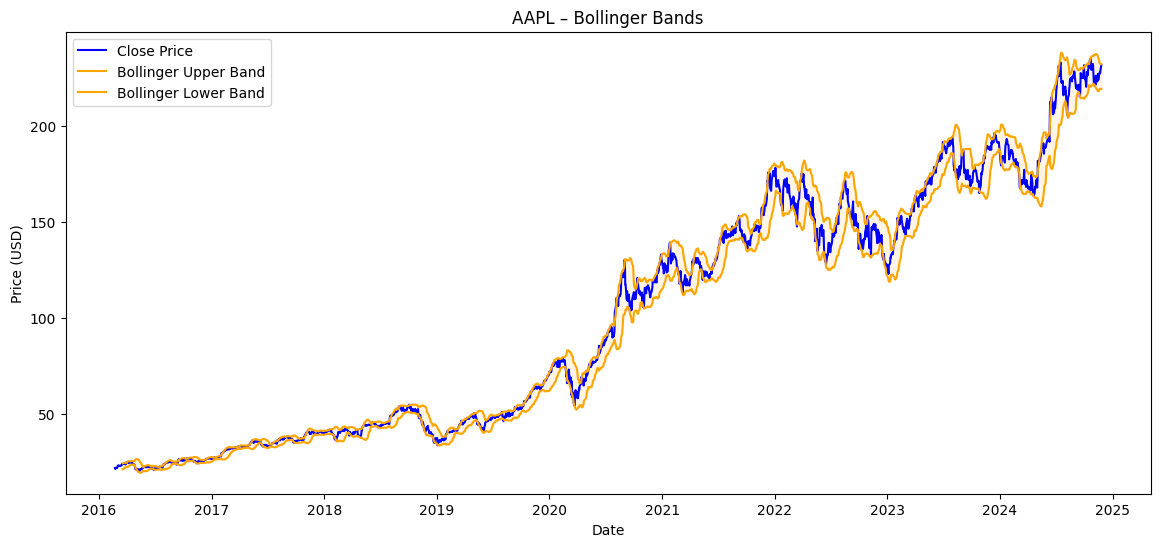

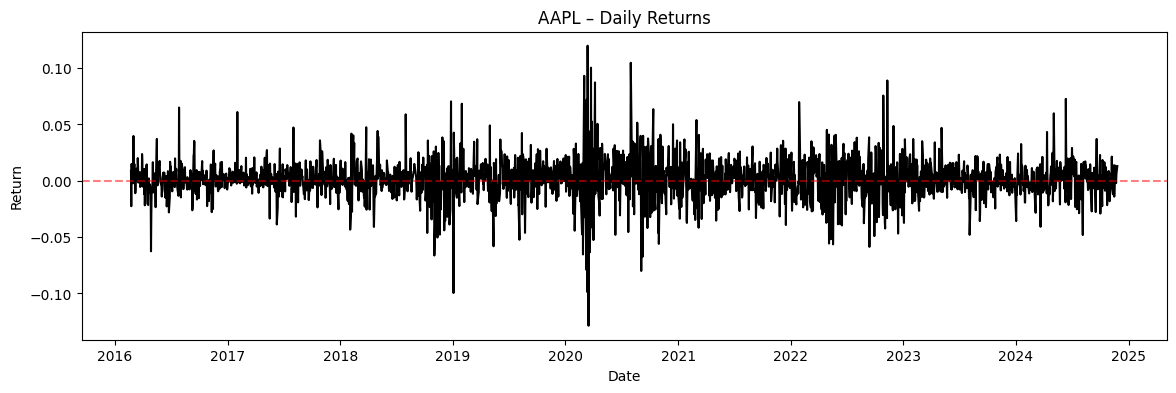

                       Date       Open       High        Low      Close  \
1 2016-02-22 00:00:00-05:00  21.832741  21.966491  21.744332  21.961956   
2 2016-02-23 00:00:00-05:00  21.853144  21.875812  21.433763  21.465500   
3 2016-02-24 00:00:00-05:00  21.304543  21.848603  21.154925  21.785130   
4 2016-02-25 00:00:00-05:00  21.773808  21.934759  21.592453  21.934759   
5 2016-02-26 00:00:00-05:00  22.034501  22.220388  21.893953  21.968761   

      Volume    Return  SMA_10  SMA_30     EMA_10     EMA_30  BB_high  BB_low  
1  137123200  0.008746     NaN     NaN  21.961956  21.961956      NaN     NaN  
2  127770400 -0.022605     NaN     NaN  21.871691  21.929927      NaN     NaN  
3  145022800  0.014890     NaN     NaN  21.855953  21.920585      NaN     NaN  
4  110330800  0.006868     NaN     NaN  21.870281  21.921499      NaN     NaN  
5  115964400  0.001550     NaN     NaN  21.888187  21.924548      NaN     NaN  


In [ ]:

# Import  libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import plotly.graph_objects as go


# Download Apple stock data

ticker = yf.Ticker("AAPL")
df = ticker.history(start="2016-02-19", end="2024-11-26")
df.reset_index(inplace=True)

# Data cleaning

df.dropna(inplace=True)
df.sort_values("Date", inplace=True)
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Price trend plot

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df['Date'],
        y=df['Close'],
        mode='lines',
        name='Close Price',
        line=dict(color='black', width=1)
    )
)

fig.update_layout(
    title='Apple Inc. (AAPL) Stock Price',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='simple_white',
    height=400,
    showlegend=False
)

fig.show()


# daily returns

df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)

# Feature engineering and visualizations

df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

bb = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
df['BB_high'] = bb.bollinger_hband()
df['BB_low'] = bb.bollinger_lband()

# SMA plot
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['SMA_10'], label='SMA 10', color='orange')
plt.plot(df['Date'], df['SMA_30'], label='SMA 30', color='red')
plt.title("AAPL – Price with Simple Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# EMA plot
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['EMA_10'], label='EMA 10', linestyle='--', color='green')
plt.plot(df['Date'], df['EMA_30'], label='EMA 30', linestyle='--', color='purple')
plt.title("AAPL – Price with Exponential Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Bollinger Bands
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['BB_high'], label='Bollinger Upper Band', color='orange')
plt.plot(df['Date'], df['BB_low'], label='Bollinger Lower Band', color='orange')
plt.fill_between(df['Date'], df['BB_low'], df['BB_high'], color='orange', alpha=0.1)
plt.title("AAPL – Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Daily returns
plt.figure(figsize=(14,4))
plt.plot(df['Date'], df['Return'], color='black')
plt.axhline(0, linestyle='--', color='red', alpha=0.5)
plt.title("AAPL – Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

print(df.head())


This is our starting dataset.

https://www.kaggle.com/datasets/frankossai/apple-stock-aapl-historical-financial-news-data

"Apple Stock (AAPL): Historical Financial News Data is a comprehensive dataset spanning nearly nine years, from February 19, 2016, to November 27, 2024, capturing detailed information about financial news articles related to Apple Inc. (AAPL). It contains 29,752 entries, each representing a unique news article with associated metadata, sentiment analysis, and relevance to Apple stock."

This dataset already has a sentiment analysis column, but there are no details on how it was done, so using the texts of the 'cleaned' articles we will perform our own using FinBERT.



Let's load it up and do some cleaning for our encoder.

In [ ]:
import pandas as pd
from google.colab import files
from datetime import datetime
import re

# Load the file
df = pd.read_csv('/content/apple_news_data.csv')
print(f"Found {len(df)} total news articles")

# 1. Convert the date column to datetime and make it timezone-naive, then filter up to 2024-11-26
df['date'] = pd.to_datetime(df['date']).dt.tz_convert(None)
cutoff_date = datetime(2024, 11, 26)
df_filtered = df[df['date'] <= cutoff_date].copy()  # Use a copy to avoid SettingWithCopyWarning

# 2. Select only the date and content columns (renamed to text)
df_clean = df_filtered[['date', 'content']].rename(columns={'content': 'text'})

# 3. Clean the text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)  # Remove URLs and mentions
    text = re.sub(r"[^a-zA-Z\s.,!?]", "", text)  # Keep basic punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

df_clean['text'] = df_clean['text'].apply(clean_text)

# 4. Remove rows with empty or very short text
df_clean = df_clean[df_clean['text'].str.len() >= 50]

# 5. Format the date as a string YYYY-MM-DD (without time)
df_clean['date'] = df_clean['date'].dt.strftime('%Y-%m-%d')

# Display a preview
print(f"Rows retained after filtering and cleaning: {len(df_clean)}")
display(df_clean.head())

# Save the result
clean_filename = 'apple_news_2024_cleaned.csv'
df_clean.to_csv(clean_filename, index=False)
files.download(clean_filename)
print("\n Analysis completed! File saved as:", clean_filename)


Found 29752 total news articles
Rows retained after filtering and cleaning: 29567


,date,text
2,2024-11-26,"Could Investing , in Apple Make You a Milliona..."
6,2024-11-24,The election is leading to a return of persona...
7,2024-11-23,Warren Buffett Unloaded More Apple Shares in Q...
8,2024-11-23,Warren Buffett still holds a massive stake in ...
9,2024-11-23,Apple Intelligence is just the companys latest...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Analysis completed! File saved as: apple_news_2024_cleaned.csv


*RoBERTa* is effective at capturing informal language, irony, and slang typically found in Twitter data. FinBERT, instead, is specifically designed to recognize finance-related terminology and market-specific expressions. Since our model focuses exclusively on news articles rather than social media content, FinBERT is more appropriate due to its domain adaptation to the financial context. Previous studies have shown that these models perform well on Twitter data, and that the previously mentioned domain adaptation is crucial for achieving accurate and robust sentiment analysis results

In [ ]:
#  Load Data
import pandas as pd
from tqdm import tqdm
import torch

# Load the news dataset
df = pd.read_csv('/content/apple_news_2024_cleaned.csv')
print(f"Found {len(df)} total news articles")

#  FinBERT Model Setup
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
    truncation=True,
    max_length=512
)

# Sentiment Analysis
def analyze_all_texts(text_list, batch_size=32):
    results = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Sentiment Analysis"):
        batch = text_list[i:i + batch_size]
        try:
            batch_results = sentiment_pipeline(batch)
            results.extend(batch_results)
        except Exception as e:
            print(f"\nError in batch {i}-{i+batch_size}: {str(e)}")
            results.extend([{'label': 'neutral', 'score': 1.0}] * len(batch))
    return results

news_list = df['text'].astype(str).tolist()  # Use 'text' column
sentiment_results = analyze_all_texts(news_list)

# Convert Labels to Continuous Values
def convert_to_continuous(label, score):
    if label.lower() == 'negative':
        return -score
    elif label.lower() == 'positive':
        return score
    else:  # neutral
        return score

df['sentiment_label'] = [res['label'] for res in sentiment_results]
df['sentiment_score'] = [res['score'] for res in sentiment_results]
df['sentiment_continuous'] = df.apply(
    lambda x: convert_to_continuous(x['sentiment_label'], x['sentiment_score']),
    axis=1
)

# Summary Statistics
print("\n=== Final Statistics ===")
print(f"Processed news articles: {len(df)}")
print("\nCategorical distribution:")
print(df['sentiment_label'].value_counts(normalize=True).map("{:.1%}".format))
print("\nContinuous sentiment statistics:")
print(f"Mean: {df['sentiment_continuous'].mean():.3f}")
print(f"Min: {df['sentiment_continuous'].min():.3f}")
print(f"Max: {df['sentiment_continuous'].max():.3f}")

# Daily Average Sentiment
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' column is datetime
daily_sentiment = df.groupby('date')['sentiment_continuous'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_continuous': 'daily_avg_sentiment'}, inplace=True)

print("\n=== Daily Average Sentiment Preview ===")
print(daily_sentiment.head())

# Save daily averages
daily_output_file = "daily_sentiment_avg.csv"
daily_sentiment.to_csv(daily_output_file, index=False)

# Visualization
import matplotlib.pyplot as plt

# Histogram of continuous values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(df['sentiment_continuous'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Continuous Sentiment')
plt.xlabel('Sentiment (-1 to +1)')
plt.ylabel('Frequency')

# Pie chart of categorical labels
plt.subplot(1, 2, 2)
df['sentiment_label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['tomato', 'gold', 'limegreen']
)
plt.title('Categorical Sentiment Distribution')
plt.tight_layout()
plt.show()

# Line chart of daily average sentiment
plt.figure(figsize=(12,5))
plt.plot(daily_sentiment['date'], daily_sentiment['daily_avg_sentiment'], marker='o')
plt.title('Daily Average Sentiment Trend')
plt.xlabel('Date')
plt.ylabel('Average Sentiment (-1 to +1)')
plt.grid(True)
plt.show()

# Save Full Dataset
output_file = "news_until_2024-11-26.csv"
df.to_csv(output_file, index=False)

print("\nAnalysis completed! Files saved as:", output_file, "and", daily_output_file)


Found 29567 total news articles


Device set to use cpu
Sentiment Analysis:  32%|███▏      | 295/924 [3:14:11<5:58:31, 34.20s/it]

In [ ]:
import pandas as pd

# Load the full news dataset
df7 = pd.read_csv('/content/news_da_2016-02-19_fino_2024-11-26.csv')

# Save a “bare” version (without article titles or content, only sentiment scores)
df7.drop(columns=['text', 'sentiment_label', 'sentiment_score']).to_csv(
    "news_da_2016-02-19_fino_2024-11-26_bare.csv", index=False
)

# Note: "bare" here is an artistic way of saying the file contains only sentiment data, without article titles or content.


In [ ]:

df_news = pd.read_csv('/content/news_da_2016-02-19_fino_2024-11-26_bare.csv')
df_news = df_news.rename(columns={'date': 'Date'})


We rename the column to facilitate merging with the df we get from yfinance, with its own indicators and perform some feature engineering.

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Download market data
ticker = 'AAPL'
df = yf.download(ticker, start="2016-02-19", end="2024-11-26")
if isinstance(df.columns, pd.MultiIndex):
   df.columns = [col[0] for col in df.columns]

# Keep only Close and Volume
df = df[["Close", "Volume"]]

# Feature engineering
df['Return'] = df['Close'].pct_change()
df['MA_10'] = df['Close'].rolling(10, min_periods=1).mean()
df['MA_30'] = df['Close'].rolling(30, min_periods=1).mean()
df['Price_Change'] = df['Close'].pct_change()
df['MA_Diff'] = df['MA_10'] - df['MA_30']

# EMA_10 and EMA_30
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

df['EMA_Diff'] = df['EMA_10'] - df['EMA_30']

# Calculate Bollinger Bands
window = 20
df['BB_middle'] = df['Close'].rolling(window=window).mean()
df['BB_std'] = df['Close'].rolling(window=window).std()
df['BB_high'] = df['BB_middle'] + (df['BB_std'] * 2)
df['BB_low'] = df['BB_middle'] - (df['BB_std'] * 2)

df['BB_Position'] = (df['Close'] - df['BB_low']) / (df['BB_high'] - df['BB_low'])
df['Volume_MA'] = df['Volume'] / df['Volume'].rolling(5).mean()
df['Volatility'] = df['Return'].rolling(window=10).std()
df['Momentum_5d'] = df['Close'] / df['Close'].shift(5) - 1

# Target = next day return
df['Target'] = df['Return'].shift(-1)

df = df.reset_index()

# Convert 'Date' column in df_news to datetime to match df
df_news['Date'] = pd.to_datetime(df_news['Date'])

df = df.merge(
    df_news,
    on='Date',
    how='left'
)


Let's eliminate the period where some features are missing.

In [ ]:
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define the start and end dates of the period to be removed
start_date_to_remove = pd.to_datetime('2016-02-19')
end_date_to_remove = pd.to_datetime('2017-10-05')

# Filter out rows where 'Date' falls within the specified range
df = df[~((df['Date'] >= start_date_to_remove) & (df['Date'] <= end_date_to_remove))]

# Filter out rows where 'sentiment_continuous' is NaN
df = df.dropna(subset=['sentiment_continuous'])

# Reset the index of the DataFrame after filtering
df = df.reset_index(drop=True)


Let's call our dataset: df_con_indicatori.

## Final Classification Model


We first note that the target is not a simple binary “Will the stock go up or not?” A 0.1% increase in the stock price would count as a “success” for the model, but it would not generate profit in practice, as trading costs would cancel out any gains. Therefore, we define a significant upward movement as being above the 60th percentile.
We construct features that capture trend, momentum, volatility, volume, and market sentiment. The data is cleaned using interpolation, and the most important features are selected via Random Forest to reduce noise and model complexity. Features are then scaled and organized into 20-day temporal sequences to capture dynamic patterns.
The dataset is split temporally into training, validation, and test sets. We use Conv1D layers to detect local patterns and technical microstructures, and Bidirectional LSTM layers to learn temporal dependencies and market context. The model is trained to maximize meaningful performance metrics, employing early stopping and adaptive learning rates to ensure robust learning.

=== CARICAMENTO E PREPARAZIONE DATI ===


/tmp/ipython-input-3098511144.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(method='ffill', inplace=True)
/tmp/ipython-input-3098511144.py:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean[col].fillna(method='ffill', inplace=True)
/tmp/ipython-input-3098511144.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The beha

Dati dopo pulizia: (26427, 19)
Balance target: 0.063

Top 10 Feature Importance:
                 feature  importance
11              EMA_Diff    0.104529
14           BB_Position    0.095709
15  sentiment_continuous    0.094162
13                BB_low    0.092075
9                 EMA_30    0.091019
12               BB_high    0.088742
8                 EMA_10    0.088612
10               MA_Diff    0.054413
0                  Close    0.052571
7                  MA_30    0.052330

Feature selezionate: ['EMA_Diff', 'BB_Position', 'sentiment_continuous', 'BB_low', 'EMA_30', 'BB_high', 'EMA_10', 'MA_Diff', 'Close', 'MA_30', 'Return', 'Volume']
Train: (18484, 20, 12), Val: (3961, 20, 12), Test: (3962, 20, 12)
Balance train: 0.059
Class weights: {0: np.float64(0.5314242999252486), 1: np.float64(8.455626715462031)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 18, 32)         │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 18, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 9, 128)         │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,713 (373.88 KB)

 Trainable params: 95,201 (371.88 KB)

 Non-trainable params: 512 (2.00 KB)


=== TRAINING ===
Epoch 1/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4350 - auc: 0.5544 - loss: 1.1703 - pr_auc: 0.0783 - precision: 0.0662 - recall: 0.6399

578/578 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.4351 - auc: 0.5544 - loss: 1.1702 - pr_auc: 0.0783 - precision: 0.0662 - recall: 0.6398 - val_accuracy: 0.8611 - val_auc: 0.5501 - val_loss: 0.8777 - val_pr_auc: 0.0751 - val_precision: 0.0907 - val_recall: 0.1713 - learning_rate: 0.0010
Epoch 2/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5813 - auc: 0.6104 - loss: 1.0121 - pr_auc: 0.1252 - precision: 0.0821 - recall: 0.5894 - val_accuracy: 0.9450 - val_auc: 0.5693 - val_loss: 0.8046 - val_pr_auc: 0.0637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6160 - auc: 0.6616 - loss: 0.9127 - pr_auc: 0.1446 - precision: 0.0942 - recall: 0.6289 - val_accuracy: 0.8498 - val_auc: 0.6006 - val_loss: 0.7039 - val_pr_auc: 0.0642 - val_precision: 0.0412 - val_recall: 0.0787 - learning_rate: 0.0010
Epoch 4/100
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6478 - auc: 0.7

578/578 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6479 - auc: 0.7006 - loss: 0.8353 - pr_auc: 0.1617 - precision: 0.1050 - recall: 0.6490 - val_accuracy: 0.6602 - val_auc: 0.5951 - val_loss: 0.7824 - val_pr_auc: 0.0900 - val_precision: 0.0661 - val_recall: 0.3981 - learning_rate: 0.0010
Epoch 5/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6607 - auc: 0.7333 - loss: 0.7753 - pr_auc: 0.1700 - precision: 0.1119 - recall: 0.6720

578/578 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6607 - auc: 0.7333 - loss: 0.7752 - pr_auc: 0.1700 - precision: 0.1119 - recall: 0.6720 - val_accuracy: 0.7450 - val_auc: 0.6951 - val_loss: 0.6610 - val_pr_auc: 0.0999 - val_precision: 0.0916 - val_recall: 0.4120 - learning_rate: 0.0010
Epoch 6/100
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6771 - auc: 0.7723 - loss: 0.7170 - pr_auc: 0.1874 - precision: 0.1276 - recall: 0.7526

578/578 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6772 - auc: 0.7723 - loss: 0.7170 - pr_auc: 0.1875 - precision: 0.1276 - recall: 0.7526 - val_accuracy: 0.7677 - val_auc: 0.7313 - val_loss: 0.6360 - val_pr_auc: 0.1284 - val_precision: 0.1271 - val_recall: 0.5556 - learning_rate: 0.0010
Epoch 7/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6922 - auc: 0.7918 - loss: 0.6777 - pr_auc: 0.1928 - precision: 0.1354 - recall: 0.7686

578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.6922 - auc: 0.7918 - loss: 0.6777 - pr_auc: 0.1928 - precision: 0.1354 - recall: 0.7686 - val_accuracy: 0.6862 - val_auc: 0.7659 - val_loss: 0.6483 - val_pr_auc: 0.1443 - val_precision: 0.1233 - val_recall: 0.7778 - learning_rate: 0.0010
Epoch 8/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6925 - auc: 0.7893 - loss: 0.6672 - pr_auc: 0.1943 - precision: 0.1344 - recall: 0.7610 - val_accuracy: 0.7935 - val_auc: 0.7892 - val_loss: 0.5472 - val_pr_auc: 0.1364 - val_precision: 0.1556 - val_recall: 0.6296 - learning_rate: 0.0010
Epoch 9/100
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7050 - auc: 0.8194 - loss: 0.6238 - pr_auc: 0.2115 - precision: 0.1449 - recall: 0.8017

578/578 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7050 - auc: 0.8194 - loss: 0.6238 - pr_auc: 0.2115 - precision: 0.1449 - recall: 0.8017 - val_accuracy: 0.6822 - val_auc: 0.7895 - val_loss: 0.6197 - val_pr_auc: 0.1963 - val_precision: 0.1151 - val_recall: 0.7222 - learning_rate: 0.0010
Epoch 10/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7164 - auc: 0.8302 - loss: 0.6017 - pr_auc: 0.2311 - precision: 0.1527 - recall: 0.8214 - val_accuracy: 0.6284 - val_auc: 0.7680 - val_loss: 0.7621 - val_pr_auc: 0.1624 - val_precision: 0.1060 - val_recall: 0.7824 - learning_rate: 0.0010
Epoch 11/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7035 - auc: 0.8299 - loss: 0.5971 - pr_auc: 0.2341 - precision: 0.1473 - recall: 0.8256 - val_accuracy: 0.7172 - val_auc: 0.7873 - val_loss: 0.5953 - val_pr_auc: 0.1461 - val_precision: 0.1277 - val_recall: 0.7176 - learning_rate: 0.0010
Epoch 12/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7197 - auc: 0.8413 

578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7098 - auc: 0.8464 - loss: 0.5616 - pr_auc: 0.2381 - precision: 0.1536 - recall: 0.8534 - val_accuracy: 0.7082 - val_auc: 0.8177 - val_loss: 0.5577 - val_pr_auc: 0.1971 - val_precision: 0.1334 - val_recall: 0.7917 - learning_rate: 0.0010
Epoch 16/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7298 - auc: 0.8707 - loss: 0.5223 - pr_auc: 0.2698 - precision: 0.1675 - recall: 0.8845 - val_accuracy: 0.7294 - val_auc: 0.8079 - val_loss: 0.5468 - val_pr_auc: 0.1656 - val_precision: 0.1415 - val_recall: 0.7824 - learning_rate: 0.0010
Epoch 17/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7447 - auc: 0.8741 - loss: 0.5142 - pr_auc: 0.2635 - precision: 0.1726 - recall: 0.8607

578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7447 - auc: 0.8740 - loss: 0.5142 - pr_auc: 0.2634 - precision: 0.1726 - recall: 0.8607 - val_accuracy: 0.7122 - val_auc: 0.8142 - val_loss: 0.5613 - val_pr_auc: 0.2133 - val_precision: 0.1345 - val_recall: 0.7870 - learning_rate: 0.0010
Epoch 18/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7405 - auc: 0.8731 - loss: 0.5234 - pr_auc: 0.2853 - precision: 0.1744 - recall: 0.8940

578/578 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7405 - auc: 0.8731 - loss: 0.5234 - pr_auc: 0.2853 - precision: 0.1744 - recall: 0.8940 - val_accuracy: 0.7071 - val_auc: 0.7882 - val_loss: 0.6005 - val_pr_auc: 0.2211 - val_precision: 0.1230 - val_recall: 0.7130 - learning_rate: 0.0010
Epoch 19/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.7457 - auc: 0.8767 - loss: 0.5062 - pr_auc: 0.2620 - precision: 0.1782 - recall: 0.8982 - val_accuracy: 0.6370 - val_auc: 0.8100 - val_loss: 0.7199 - val_pr_auc: 0.1845 - val_precision: 0.1172 - val_recall: 0.8657 - learning_rate: 0.0010
Epoch 20/100
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - auc: 0.8840 - loss: 0.4957 - pr_auc: 0.2939 - precision: 0.1785 - recall: 0.8809

578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7500 - auc: 0.8840 - loss: 0.4957 - pr_auc: 0.2938 - precision: 0.1785 - recall: 0.8809 - val_accuracy: 0.6930 - val_auc: 0.8253 - val_loss: 0.6199 - val_pr_auc: 0.2311 - val_precision: 0.1324 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 21/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7594 - auc: 0.8940 - loss: 0.4650 - pr_auc: 0.2927 - precision: 0.1900 - recall: 0.9243 - val_accuracy: 0.6269 - val_auc: 0.8020 - val_loss: 0.6974 - val_pr_auc: 0.1620 - val_precision: 0.1129 - val_recall: 0.8519 - learning_rate: 0.0010
Epoch 22/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.7475 - auc: 0.8846 - loss: 0.4885 - pr_auc: 0.2880 - precision: 0.1783 - recall: 0.8922 - val_accuracy: 0.6223 - val_auc: 0.7737 - val_loss: 0.6487 - val_pr_auc: 0.2007 - val_precision: 0.1078 - val_recall: 0.8148 - learning_rate: 0.0010
Epoch 23/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7459 - auc: 0.8878 

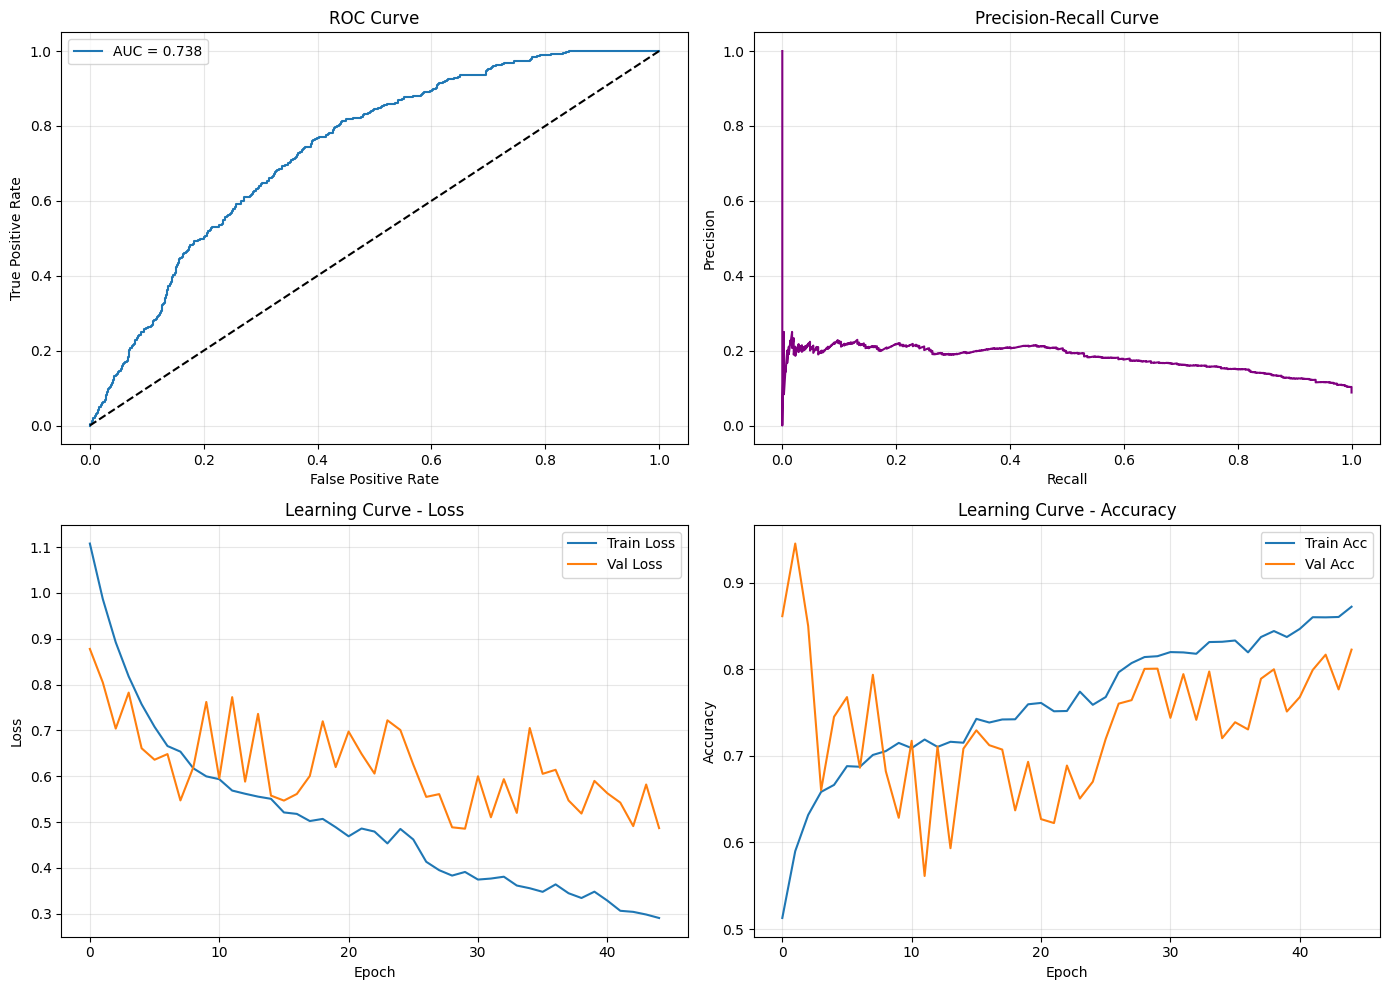

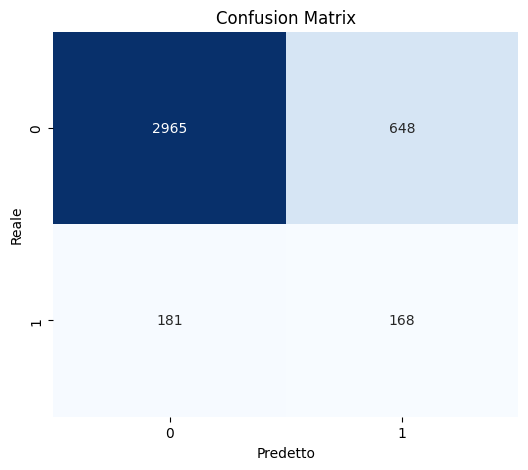

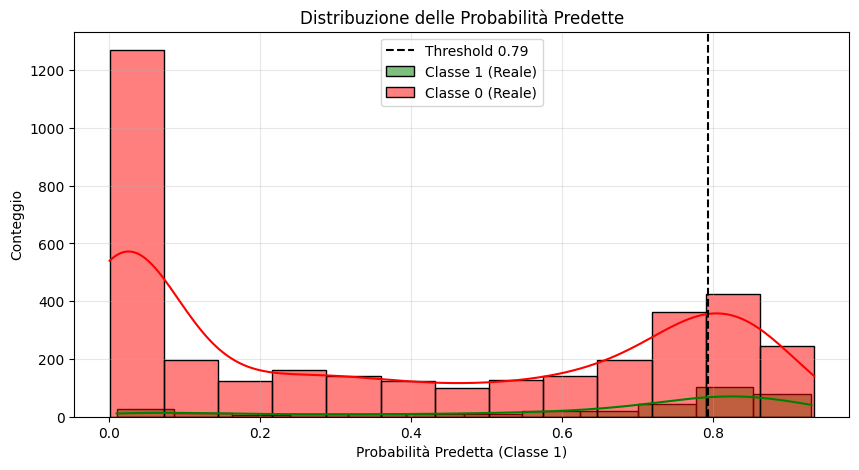

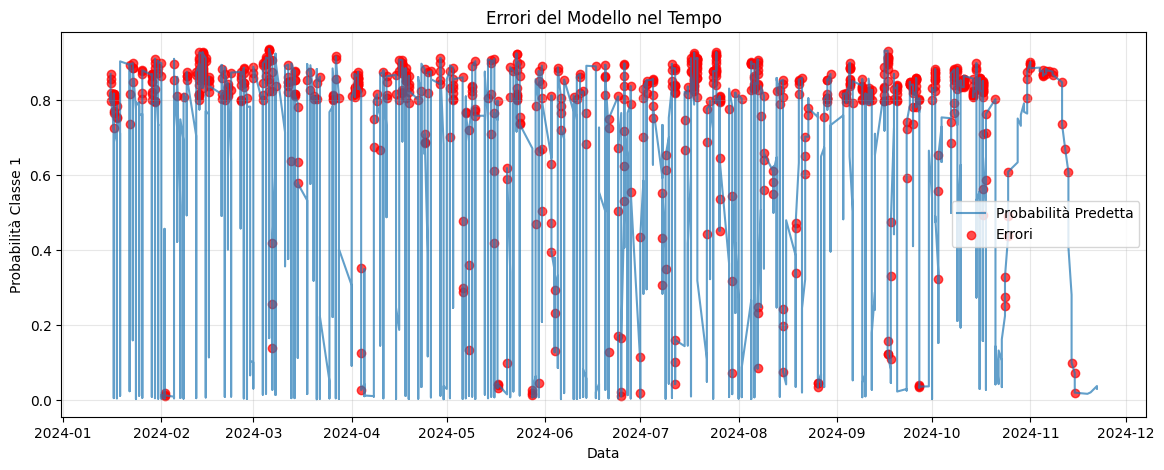

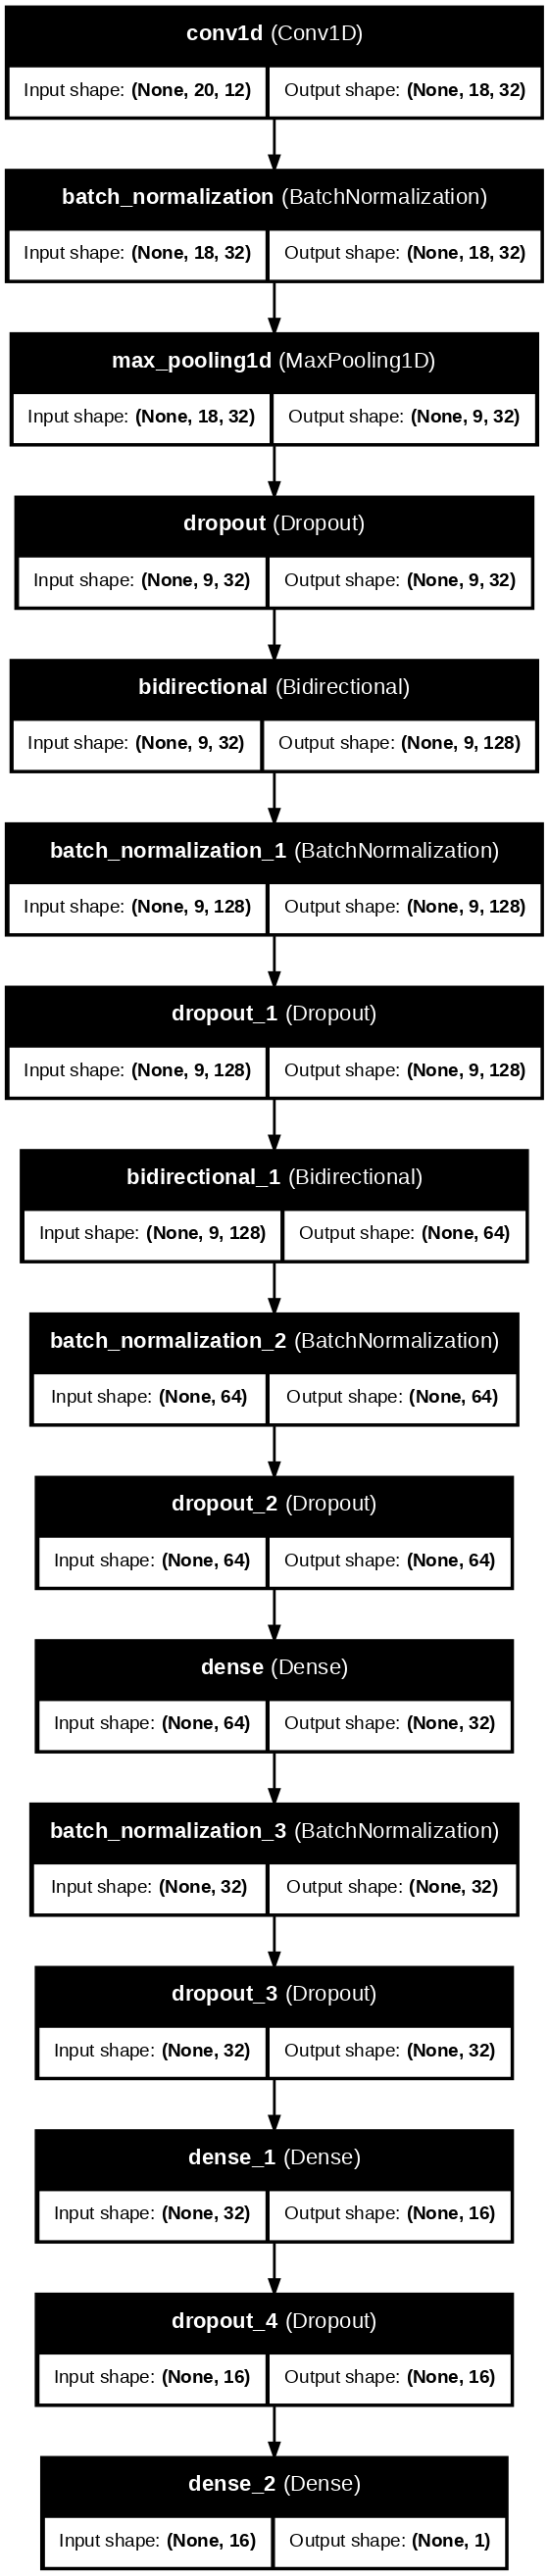


✅ ANALISI COMPLETATA CON SUCCESSO!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, f1_score, precision_score, recall_score, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model

# Configuration
np.random.seed(42)
tf.random.set_seed(42)

print(" Data loading ")
df = pd.read_csv("/content/df_con_indicatori.csv")

#  Convert the Date column to datetime
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

# Feature engineering performed earlier
df['Price_Change'] = df['Close'].pct_change()
df['MA_Diff'] = df['MA_10'] - df['MA_30']
df['EMA_Diff'] = df['EMA_10'] - df['EMA_30']
df['BB_Position'] = (df['Close'] - df['BB_low']) / (df['BB_high'] - df['BB_low'])
df['Volume_MA'] = df['Volume'] / df['Volume'].rolling(5).mean()
df['Volatility'] = df['Return'].rolling(window=10).std()
df['Momentum_5d'] = df['Close'] / df['Close'].shift(5) - 1

#  Smarter target engineering
future_return_3d = df['Close'].pct_change(3).shift(-3)
future_return_5d = df['Close'].pct_change(5).shift(-5)

condition1 = future_return_3d > future_return_3d.quantile(0.6)
condition2 = future_return_5d > 0
condition3 = df['Volume'] > df['Volume'].rolling(20).mean()

df['Target'] = ((condition1 & condition2) | (condition1 & condition3)).astype(int)

features = [
    "Close", "Volume", "Return", "Price_Change", "Volatility", "Momentum_5d",
    "MA_10", "MA_30", "EMA_10", "EMA_30", "MA_Diff", "EMA_Diff",
    "BB_high", "BB_low", "BB_Position", "sentiment_continuous", "Volume_MA"
]

# Robust data cleaning
df_clean = df.copy()
for col in features + ['Target']:
    if df_clean[col].isnull().any():
        df_clean[col] = df_clean[col].interpolate(method='linear')
        df_clean[col].fillna(method='ffill', inplace=True)
        df_clean[col].fillna(method='bfill', inplace=True)

df_clean = df_clean.dropna(subset=features + ['Target'])
print(f"Data after cleaning: {df_clean.shape}")
print(f"Target balance: {df_clean['Target'].mean():.3f}")

#  Feature selection with Random Forest
X_temp = df_clean[features].values
y_temp = df_clean['Target'].values
X_sample, _, y_sample, _ = train_test_split(X_temp, y_temp, test_size=0.7, random_state=42, stratify=y_temp)
rf_selector = RandomForestClassifier(n_estimators=50, random_state=42)
rf_selector.fit(X_sample, y_sample)

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importance:")
print(feature_importance.head(10))

selected_features = feature_importance.head(12)['feature'].tolist()
print(f"\nSelected features: {selected_features}")

X = df_clean[selected_features].values
y = df_clean['Target'].values

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sequences
sequence_length = 20
X_seq, y_seq, dates_seq = [], [], []
for i in range(sequence_length, len(X_scaled)):
    X_seq.append(X_scaled[i-sequence_length:i])
    y_seq.append(y[i])
    if 'Date' in df_clean.columns:
        dates_seq.append(df_clean['Date'].iloc[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Temporal split
split_idx = int(0.7 * len(X_seq))
X_train, X_temp = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_temp = y_seq[:split_idx], y_seq[split_idx:]
val_idx = int(0.5 * len(X_temp))
X_val, X_test = X_temp[:val_idx], X_temp[val_idx:]
y_val, y_test = y_temp[:val_idx], y_temp[val_idx:]
test_dates = dates_seq[split_idx + val_idx:] if dates_seq else None

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train balance: {np.mean(y_train):.3f}")

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# Optimized model architecture
def create_optimized_model(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),

        Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dropout(0.1),

        Dense(1, activation='sigmoid')
    ])
    return model

model = create_optimized_model((X_train.shape[1], X_train.shape[2]))
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.AUC(name='pr_auc', curve='PR')]
)

model.summary()

early_stop = EarlyStopping(monitor='val_pr_auc', patience=25, restore_best_weights=True, mode='max', min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_pr_auc', save_best_only=True, mode='max')

print("\n=== TRAINING ===")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluation
model.load_weights('best_model.h5')
y_pred_proba = model.predict(X_test).flatten()

thresholds = np.linspace(0.2, 0.8, 100)
f1_scores = [f1_score(y_test, (y_pred_proba > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
y_pred_optimized = (y_pred_proba > best_threshold).astype(int)

print("\n=== FINAL PERFORMANCE ===")
print(classification_report(y_test, y_pred_optimized, digits=4))
cm = confusion_matrix(y_test, y_pred_optimized)
print("Confusion Matrix:")
print(cm)

precision = precision_score(y_test, y_pred_optimized)
recall = recall_score(y_test, y_pred_optimized)
accuracy = accuracy_score(y_test, y_pred_optimized)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 MAIN METRICS:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {best_f1:.4f}")
print(f"AUC: {auc:.4f}")


# New performance and error plots


from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

#  ROC, PR, LEARNING CURVES
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve, color="purple")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Learning Curve - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Learning Curve - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#  VISUAL CONFUSION MATRIX
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#  PREDICTED PROBABILITY DISTRIBUTION
plt.figure(figsize=(10, 5))
sns.histplot(y_pred_proba[y_test == 1], color='green', kde=True, label='Class 1 (Actual)')
sns.histplot(y_pred_proba[y_test == 0], color='red', kde=True, label='Class 0 (Actual)')
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Threshold {best_threshold:.2f}')
plt.title("Predicted Probability Distribution")
plt.xlabel("Predicted Probability (Class 1)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ERRORS OVER TIME
if test_dates is not None and len(test_dates) == len(y_test):
    plt.figure(figsize=(14, 5))
    plt.plot(test_dates, y_pred_proba, label='Predicted Probability', alpha=0.7)
    plt.scatter(np.array(test_dates)[y_pred_optimized != y_test],
                y_pred_proba[y_pred_optimized != y_test],
                color='red', label='Errors', alpha=0.7)
    plt.title("Model Errors Over Time")
    plt.xlabel("Date")
    plt.ylabel("Class 1 Probability")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# MODEL ARCHITECTURE
plot_model(
    model,
    to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)
from IPython.display import Image
display(Image(filename="model_architecture.png"))

print("\n✅ ANALYSIS COMPLETED SUCCESSFULLY!")


The model demonstrates a concrete ability to extract useful information from highly noisy financial data. The predictive performance, measured by a ROC AUC of approximately 0.74, indicates the presence of a statistically significant edge, suggesting that the model is able to discriminate better than a purely random strategy. A recall of around 48% shows that the model captures nearly one opportunity out of two, while a precision of approximately 20% indicates that a substantial portion of the generated signals is noisy. In other words, the model correctly identifies almost one opportunity out of two (as reflected by the 48% recall), but does so at the cost of producing a large number of false positives.

# Final XGBoost Model


In [ ]:
!pip install yfinance xgboost optuna torch torchvision torchaudio scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("/content/df_con_indicatori.csv")

#   Convert the Date column to datetime
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# DATA LOADING AND PREPARATION

df = pd.read_csv("/content/df_con_indicatori.csv")

if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

# Feature engineering
df['Price_Change'] = df['Close'].pct_change()
df['MA_Diff'] = df['MA_10'] - df['MA_30']
df['EMA_Diff'] = df['EMA_10'] - df['EMA_30']
df['BB_Position'] = (df['Close'] - df['BB_low']) / (df['BB_high'] - df['BB_low'])
df['Volume_MA'] = df['Volume'] / df['Volume'].rolling(5).mean()
df['Volatility'] = df['Return'].rolling(10).std()
df['Momentum_5d'] = df['Close'] / df['Close'].shift(5) - 1

df = df.dropna().reset_index(drop=True)

target_col = "Return"
feature_cols = [
    'Close','Volume','MA_10','MA_30','EMA_10','EMA_30',
    'BB_low','BB_high','Price_Change','MA_Diff','EMA_Diff',
    'BB_Position','Volume_MA','Volatility','Momentum_5d',
    'sentiment_continuous'
]

X = df[feature_cols].values
Y = df[target_col].values
dates = df["Date"].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# LSTM Dataset and Model

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y, seq_len=60):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx:idx+self.seq_len], dtype=torch.float32),
            torch.tensor(self.Y[idx+self.seq_len], dtype=torch.float32)
        )

class LSTMModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.lstm = nn.LSTM(n_features, 128, 2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()


#  TRAIN + STACKING

ts_split = TimeSeriesSplit(n_splits=5)
seq_len = 60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lstm_oof = np.zeros(len(X))
xgb_oof = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(ts_split.split(X_scaled)):
    print(f"\n----- FOLD {fold+1} -----")

    X_train, Y_train = X_scaled[train_idx], Y[train_idx]
    X_val, Y_val = X_scaled[val_idx], Y[val_idx]

    # LSTM
    train_ds = TimeSeriesDataset(X_train, Y_train, seq_len)
    val_ds   = TimeSeriesDataset(X_val, Y_val, seq_len)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
    val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

    model = LSTMModel(X.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    #  No early stopping, fixed training
    for epoch in range(15):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # LSTM predictions
    model.eval()
    preds_lstm = []
    with torch.no_grad():
        for xb, _ in val_loader:
            preds_lstm.extend(model(xb.to(device)).cpu().numpy())

    lstm_oof[val_idx[seq_len:]] = preds_lstm

    # XGBoost
    xgb_model = xgb.XGBRegressor(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    )
    xgb_model.fit(X_train[seq_len:], Y_train[seq_len:])
    preds_xgb = xgb_model.predict(X_val[seq_len:])
    xgb_oof[val_idx[seq_len:]] = preds_xgb


# META LEARNER + METRICS (WITHOUT MAPE)

valid_idx = np.where(lstm_oof != 0)[0]

meta_X = np.vstack([lstm_oof[valid_idx], xgb_oof[valid_idx]]).T
meta_Y = Y[valid_idx]

meta = Ridge()
meta.fit(meta_X, meta_Y)
meta_pred = meta.predict(meta_X)

#  Metrics WITHOUT MAPE
rmse = np.sqrt(mean_squared_error(meta_Y, meta_pred))
mae  = mean_absolute_error(meta_Y, meta_pred)
r2   = r2_score(meta_Y, meta_pred)

print("\n=== MODEL METRICS ===")
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)


#  ADVANCED PLOTS (WITHOUT BACKTEST)


#  Meta vs Real
plt.figure(figsize=(14,6))
plt.plot(dates[valid_idx], meta_Y, label="Real")
plt.plot(dates[valid_idx], meta_pred, label="Meta-Pred", alpha=0.8)
plt.title("Meta-Learner OOF: Pred vs Real")
plt.legend()
plt.grid()
plt.show()

# LSTM vs Real
plt.figure(figsize=(14,6))
plt.plot(dates[valid_idx], meta_Y, label="Real")
plt.plot(dates[valid_idx], lstm_oof[valid_idx], label="LSTM", alpha=0.7)
plt.title("LSTM OOF: Pred vs Real")
plt.legend()
plt.grid()
plt.show()

# XGBoost vs Real
plt.figure(figsize=(14,6))
plt.plot(dates[valid_idx], meta_Y, label="Real")
plt.plot(dates[valid_idx], xgb_oof[valid_idx], label="XGBoost", alpha=0.7)
plt.title("XGBoost OOF: Pred vs Real")
plt.legend()
plt.grid()
plt.show()

# Total Comparison
plt.figure(figsize=(14,6))
plt.plot(dates[valid_idx], meta_Y, label="Real", linewidth=2)
plt.plot(dates[valid_idx], lstm_oof[valid_idx], label="LSTM", alpha=0.6)
plt.plot(dates[valid_idx], xgb_oof[valid_idx], label="XGB", alpha=0.6)
plt.plot(dates[valid_idx], meta_pred, label="Meta", linewidth=2)
plt.title("Model Comparison")
plt.legend()
plt.grid()
plt.show()


# SHAP VALUES FOR XGBOOST

import shap

print("\nCalculating SHAP values for XGBoost...")

# Use the last trained XGBoost model (xgb_model)
explainer = shap.TreeExplainer(xgb_model)

# SHAP on valid OOF data (same as meta learner)
X_shap = X_scaled[valid_idx]

# Calculate SHAP values
shap_values = explainer.shap_values(X_shap)


# Plot SHAP feature importance (bar)

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_shap, feature_names=feature_cols, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP - XGBoost)")
plt.tight_layout()
plt.show()


# Full SHAP plot (beeswarm)

shap.summary_plot(shap_values, X_shap, feature_names=feature_cols)



----- FOLD 1 -----

----- FOLD 2 -----

----- FOLD 3 -----


KeyboardInterrupt: 

Although we created the ensemble to combine XGB’s ability to detect non-linear interactions and local thresholds with the LSTM’s ability to capture sequential patterns and temporal dynamics (e.g., micro-regimes, long autocorrelations), we notice from the plots that the errors of LSTM and XGB are often correlated. Let’s examine this dynamic more closely:

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def metrics(y, yhat):
    rmse = np.sqrt(mean_squared_error(y, yhat))
    mae  = mean_absolute_error(y, yhat)
    r2   = r2_score(y, yhat)
    return rmse, mae, r2

valid_idx = np.where(lstm_oof != 0)[0]
y_true = meta_Y

rmse_xgb, mae_xgb, r2_xgb = metrics(y_true, xgb_oof[valid_idx])
rmse_lstm, mae_lstm, r2_lstm = metrics(y_true, lstm_oof[valid_idx])
rmse_meta, mae_meta, r2_meta = metrics(y_true, meta_pred)

print("XGB  -> RMSE, MAE, R2:", rmse_xgb, mae_xgb, r2_xgb)
print("LSTM -> RMSE, MAE, R2:", rmse_lstm, mae_lstm, r2_lstm)
print("META -> RMSE, MAE, R2:", rmse_meta, mae_meta, r2_meta)

Comparing the results, XGB alone performs better.


One possible explanation lies in the nature of LSTM models, which require large amounts of data to correctly learn significant temporal dependencies. However, in the case of financial time series, increasing the amount of historical data does not necessarily improve predictive capability. Financial markets are characterized by strong non-stationarity and frequent structural regime changes, such as those observed during systemic crises (e.g., the 2008 crash or the Covid-19 pandemic). In such contexts, a sequential model can learn historical patterns that are no longer representative of current market dynamics, introducing bias and degrading out-of-sample performance.


Moreover, financial data exhibit a high level of noise. In sequential models like LSTMs, small prediction errors can propagate through the network’s internal state. This phenomenon makes such models particularly sensitive to noise and potentially unstable during prediction.


Classification-based approaches tend to be more robust than return regression models, as they are less sensitive to error propagation. We also highlight the importance of the continuous sentiment in both models; in the regression model, the SHAP value is lower compared to that in the classification model.


XGBoost shows a structural advantage because it does not rely on explicit temporal memory and instead focuses on local and non-linear relationships among engineered features. This characteristic makes it better suited to capture stable short-term patterns.


We now try XGBoost alone.

FOLD 1
FOLD 2
FOLD 3
FOLD 4
FOLD 5

=== METRICHE XGBOOST ===
RMSE: 0.007534750911145763
MAE : 0.004930630653489532
R²  : 0.8138930994949252


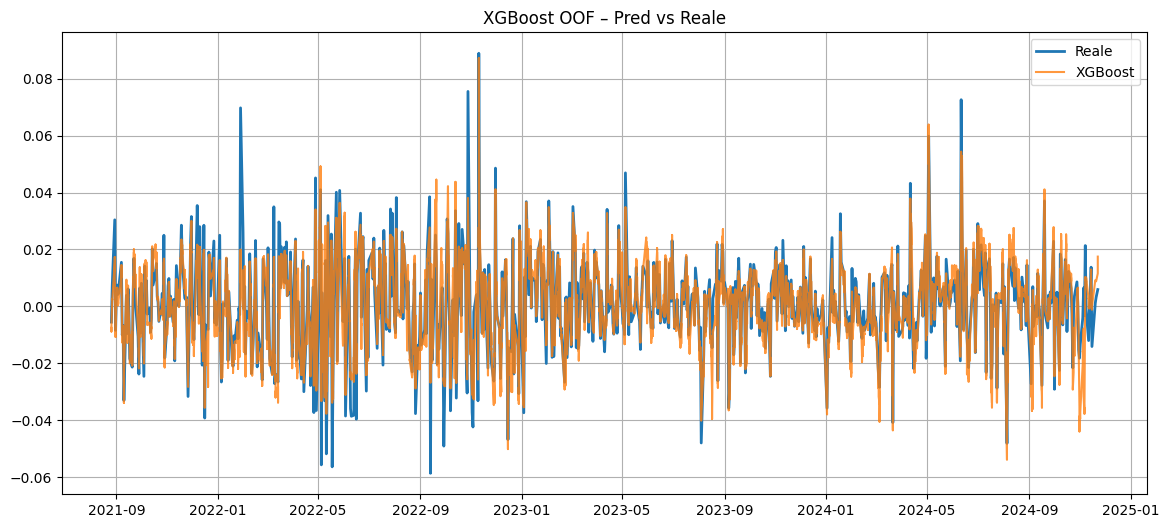

/tmp/ipython-input-79512093.py:123: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


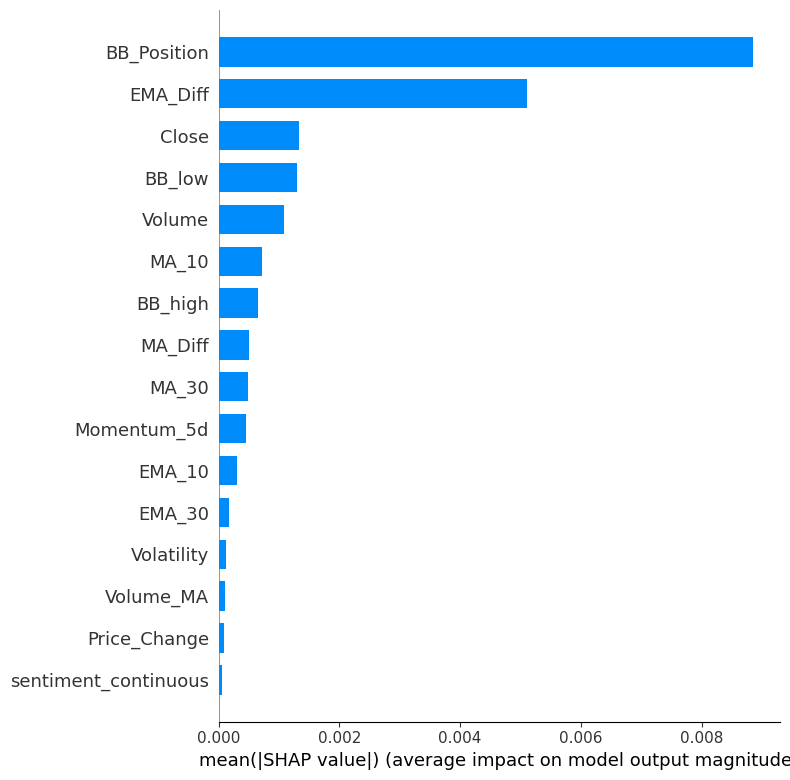

/tmp/ipython-input-79512093.py:131: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


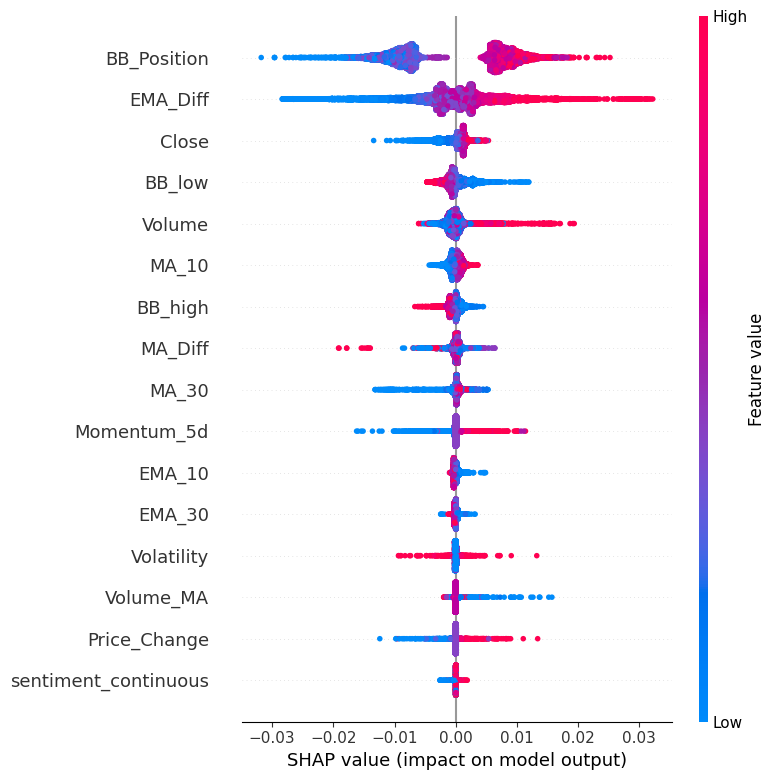

In [ ]:
# IMPORT

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# LOAD DATA

df = pd.read_csv("/content/df_con_indicatori.csv")

if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)


# FEATURE ENGINEERING

df["Price_Change"] = df["Close"].pct_change()
df["MA_Diff"] = df["MA_10"] - df["MA_30"]
df["EMA_Diff"] = df["EMA_10"] - df["EMA_30"]
df["BB_Position"] = (df["Close"] - df["BB_low"]) / (df["BB_high"] - df["BB_low"])
df["Volume_MA"] = df["Volume"] / df["Volume"].rolling(5).mean()
df["Volatility"] = df["Return"].rolling(10).std()
df["Momentum_5d"] = df["Close"] / df["Close"].shift(5) - 1

df = df.dropna().reset_index(drop=True)


# FEATURES / TARGET

target_col = "Return"
feature_cols = [
    "Close","Volume","MA_10","MA_30","EMA_10","EMA_30",
    "BB_low","BB_high","Price_Change","MA_Diff","EMA_Diff",
    "BB_Position","Volume_MA","Volatility","Momentum_5d",
    "sentiment_continuous"
]

X = df[feature_cols].values
Y = df[target_col].values
dates = df["Date"].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# XGBOOST + TIME SERIES CV (OOF)

tscv = TimeSeriesSplit(n_splits=5)
xgb_oof = np.zeros(len(X_scaled))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled)):
    print(f"FOLD {fold+1}")

    X_train, Y_train = X_scaled[train_idx], Y[train_idx]
    X_val, Y_val     = X_scaled[val_idx], Y[val_idx]

    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )

    model.fit(X_train, Y_train, verbose=False)
    xgb_oof[val_idx] = model.predict(X_val)


# METRICS

valid_idx = np.where(xgb_oof != 0)[0]

rmse = np.sqrt(mean_squared_error(Y[valid_idx], xgb_oof[valid_idx]))
mae  = mean_absolute_error(Y[valid_idx], xgb_oof[valid_idx])
r2   = r2_score(Y[valid_idx], xgb_oof[valid_idx])

print("\n=== METRICHE XGBOOST ===")
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)


# GRAFICO PRED VS REALE

plt.figure(figsize=(14,6))
plt.plot(dates[valid_idx], Y[valid_idx], label="Reale", linewidth=2)
plt.plot(dates[valid_idx], xgb_oof[valid_idx], label="XGBoost", alpha=0.8)
plt.title("XGBoost OOF – Pred vs Reale")
plt.legend()
plt.grid()
plt.show()


# SHAP

final_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

final_model.fit(X_scaled, Y)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_scaled)

# SHAP BAR
shap.summary_plot(
    shap_values,
    X_scaled,
    feature_names=feature_cols,
    plot_type="bar"
)

# SHAP BEESWARM
shap.summary_plot(
    shap_values,
    X_scaled,
    feature_names=feature_cols
)


The comparison plot between actual and predicted values shows that the model convincingly follows the overall dynamics of the time series. Although it does not perfectly replicate the most extreme peaks, the model is able to correctly trace the general trend and signal structure, a behavior consistent with a regression approach applied to highly volatile financial data.
As seen from the feature value plot, XGBoost predicts better with technical indicators because: they are numeric and normalized, and they have relatively stable historical patterns.

It struggles with the continuous sentiment (-1,1) because it is noisy, volatile, and not directly correlated.
We do not know exactly why the model is so sensitive to BB position and EMA diff, but we can assume that it is a result of the chosen target, which consists of significant increases that are precisely indicated by a moment of clear momentum (strongly increasing EMA_diff) and overbought/oversold stocks (BB position informs us about this).

# References

1. Reddit Data in Quantitative Financial Models: Evolution and Implications Post GameStop and AMC Short Squeeze

Rohan Malhotra, Colin Jones (2025)

Reddit data (particularly from r/WallStreetBets) provide predictive information on: volatility, trading volumes, and short-term returns. Granger causality tests and VAR models show that Reddit activity anticipates trading volumes during speculative episodes (GameStop, AMC). The effect is strong for small-cap/meme stocks but diminishes sharply for large-cap stocks. Advanced NLP models (LSTM, custom lexicons, LDA) improve signal quality compared to generic sentiment. Significant limitations are highlighted: noise, slang, sarcasm, and ethical and regulatory issues.

2. A Tale of Company Fundamentals vs Sentiment-Driven Pricing: The Case of GameStop
Zeeshan Umar et al. (2021)


The price of GameStop during 2021 was largely disconnected from fundamentals. The impact of sentiment is inversely proportional to market capitalization and liquidity, peaking when short interest is high and market depth is low. For larger, more liquid stocks, sentiment has weak and temporary effects.


3. The Dynamics of the Reddit Collective Action Leading to the GameStop Short Squeeze

Desiderio, Aiello, Cimini, Alessandretti (2024)


Reddit played a measurable causal role in coordinating retail investors. Granger causality: Reddit → Volumes → Prices for meme stocks. For large-cap stocks, the influence is statistically weak and lasts less than 24 hours. There is a feedback loop: high trading generates further discussion on Reddit.



4. TweetEval: Unified Benchmark and Comparative Evaluation for Tweet Classification
Francesco Barbieri et al. (EMNLP 2020)


Introduction of TweetEval, a unified benchmark for 7 NLP tasks on Twitter: sentiment, emotion, hate, offensive, stance, irony, emoji. Transformer models (RoBERTa, BERT) significantly outperform SVMs and LSTMs. Pre-training on Twitter data further improves performance. Some tasks (irony, hate) remain challenging due to lack of context.

5. Findings of EMNLP 2020 – TweetEval Analysis

Barbieri et al. (2020)

Generalist models perform surprisingly well on Twitter. However, domain adaptation improves robustness and generalization. Irony and sarcasm are better captured by models natively trained on Twitter. Conversational context remains a critical variable not fully resolved.

6. Sentiment Analysis and Stock Prediction Using Twitter Data

Knoll et al. (2019)


Twitter sentiment predicts very short-term micro-trends (intraday / 1–2 days). Accuracy ≈ 71% for technology stocks. No evidence of long-term predictive ability.


7. Bots in the Twittersphere

Pew Research Center (2018)


Significant presence of bots and automated accounts on Twitter. This increases noise, manipulation risk, and introduces spurious signals in sentiment models.


8. XGBoost: A Scalable Tree Boosting System

Tianqi Chen, Carlos Guestrin (2016)

XGBoost is a scalable, high-performance system for ensemble learning with decision trees. Its strengths include being sparsity-aware: efficient handling of sparse data (missing values, one-hot encoding), which is very useful in our case. XGBoost also outperforms scikit-learn, R GBM, Spark MLlib, H2O in speed and accuracy. Used in 17 of 29 winning Kaggle solutions in 2015.

9. Stock Trend Prediction Using News Sentiment Analysis

Kalyani Joshi, Bharathi H. N., Jyothi Rao (2016)

Methodology: Data collection from Apple Inc. news (2013–2016) and historical stock prices. Data preparation for the encoder: stop word removal, stemming, tokenization. Classification: Comparison between Naive Bayes, Random Forest, and SVM. Evaluation: Accuracy, precision, recall, ROC curve, cross-validation, and testing on new data. An observable correlation exists between news sentiment and price movement.

10. Stock Price Prediction of Apple Inc. Using News Sentiment Analysis

S. Manjunatha, R. S. Pradeep Kumar (2018)



